In [1]:
 import pandas as pd
import numpy as np

# Ignore harmless math warnings (log(0), NaN comparisons, etc.)
np.seterr(invalid='ignore', divide='ignore')

# Load dataset
df = pd.read_csv("/kaggle/input/stock-prices-csv/stock_prices.csv")

# Fix date parsing
df['Date'] = pd.to_datetime(df['Date'])

# Filter invalid trading days
df = df[df['SupervisionFlag'] == False]

# Sort data by stock and date
df = df.sort_values(['SecuritiesCode', 'Date']).reset_index(drop=True)

# --- Feature engineering (per stock) ---
g = df.groupby('SecuritiesCode', group_keys=False)

# Price-based
df['ret_1']   = g['Close'].transform(lambda x: x.pct_change(fill_method=None))  # ✅ fixed
df['log_ret'] = g['Close'].transform(lambda x: np.log(x / x.shift(1)))
df['mom_5']   = g['Close'].transform(lambda x: x / x.shift(5) - 1)


# -------------------------------
# 🔹 MOVING AVERAGES & RATIOS
# -------------------------------
df['ma_5']    = g['Close'].transform(lambda x: x.rolling(5).mean())
df['ma_20']   = g['Close'].transform(lambda x: x.rolling(20).mean())
df['ma_ratio_5_20'] = df['ma_5'] / df['ma_20']

# -------------------------------
# 🔹 VOLATILITY (Risk)
# -------------------------------
df['volatility_5']  = g['log_ret'].transform(lambda x: x.rolling(5).std())
df['volatility_20'] = g['log_ret'].transform(lambda x: x.rolling(20).std())

# -------------------------------
# 🔹 RSI (Relative Strength Index)
# -------------------------------
def rsi(series, n=14):
    delta = series.diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    rs = up.rolling(n).mean() / (down.rolling(n).mean() + 1e-9)
    return 100 - (100 / (1 + rs))

df['rsi_14'] = g['Close'].transform(rsi)

# -------------------------------
# 🔹 LAG FEATURES (to avoid lookahead)
# -------------------------------
lag_cols = [
    'ret_1', 'log_ret', 'mom_5', 'ma_5', 'ma_20', 'ma_ratio_5_20',
    'volatility_5', 'volatility_20', 'rsi_14'
]

for c in lag_cols:
    df[f'{c}_lag1'] = g[c].shift(1)

# -------------------------------
# 🔹 FINAL CLEANUP
# -------------------------------
feat_cols = [f'{c}_lag1' for c in lag_cols]

# Drop rows with missing values (initial periods per stock)
df = df.dropna(subset=feat_cols + ['Target']).reset_index(drop=True)

# ✅ Clean dataset summary
print(f"Final dataset shape: {df.shape}")
print("Feature sample:\n", df[['Date','SecuritiesCode','Close','Target'] + feat_cols].head(10))



Final dataset shape: (2215516, 30)
Feature sample:
         Date  SecuritiesCode   Close    Target  ret_1_lag1  log_ret_lag1  \
0 2017-02-03            1301  2720.0  0.002202   -0.002194     -0.002196   
1 2017-02-06            1301  2725.0  0.002197   -0.003298     -0.003303   
2 2017-02-07            1301  2731.0  0.000000    0.001838      0.001837   
3 2017-02-08            1301  2737.0  0.002923    0.002202      0.002199   
4 2017-02-09            1301  2737.0  0.013479    0.002197      0.002195   
5 2017-02-10            1301  2745.0  0.006830    0.000000      0.000000   
6 2017-02-13            1301  2782.0  0.008211    0.002923      0.002919   
7 2017-02-14            1301  2801.0  0.000354    0.013479      0.013389   
8 2017-02-15            1301  2824.0  0.000354    0.006830      0.006806   
9 2017-02-16            1301  2825.0  0.008846    0.008211      0.008178   

   mom_5_lag1  ma_5_lag1  ma_20_lag1  ma_ratio_5_20_lag1  volatility_5_lag1  \
0   -0.001464     2729.4     272

⚙️ Phase 2 — ML Model Training + Dynamic Bet Sizing Framework

🔹 Block 1 — Train/Validation Split (Time-based)
We’ll use the first 80% of time for training, last 20% for validation.

In [2]:
from sklearn.model_selection import train_test_split

# --- Time-based split ---
cutoff = df['Date'].quantile(0.8)
train_df = df[df['Date'] <= cutoff].copy()
valid_df = df[df['Date'] > cutoff].copy()

# Define features and target
X_train = train_df[feat_cols].values
y_train = (train_df['Target'] > 0).astype(int).values

X_valid = valid_df[feat_cols].values
y_valid = (valid_df['Target'] > 0).astype(int).values

print(f"Train shape: {X_train.shape}, Valid shape: {X_valid.shape}")


Train shape: (1773793, 9), Valid shape: (441723, 9)


In [3]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

# XGBoost model
xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    objective='binary:logistic'
)

# Train
xgb.fit(X_train, y_train)

# Predict probabilities
p_train = xgb.predict_proba(X_train)[:, 1]
p_valid = xgb.predict_proba(X_valid)[:, 1]

print(f"Train AUC: {roc_auc_score(y_train, p_train):.3f}")
print(f"Valid AUC: {roc_auc_score(y_valid, p_valid):.3f}")

# Update validation DataFrame
valid_df['p_hat'] = p_valid


Train AUC: 0.540
Valid AUC: 0.510


In [4]:
valid_df['p_hat'].describe()


count    441723.000000
mean          0.484837
std           0.019686
min           0.213858
25%           0.478056
50%           0.487035
75%           0.494327
max           0.804672
Name: p_hat, dtype: float64

In [5]:
# Kelly fraction (recomputed)
def kelly_fraction(p, R=1.0):
    f = p - (1 - p) / R
    return np.clip(f, 0, 1)

valid_df['kelly_fraction'] = kelly_fraction(valid_df['p_hat'], R=1.0)

# Full Kelly
alpha = 1.0
valid_df['f'] = valid_df['kelly_fraction'] * alpha

# Recompute returns
valid_df['strategy_ret'] = valid_df['f'] * valid_df['Target']
daily_ret = valid_df.groupby('Date')['strategy_ret'].mean().to_frame('r')
daily_ret['equity'] = (1 + daily_ret['r']).cumprod()

# Metrics
def sharpe_ratio(r, periods=252, rf=0):
    ex_ret = r - rf/periods
    return (np.mean(ex_ret) / (np.std(ex_ret) + 1e-9)) * np.sqrt(periods)

def max_drawdown(equity):
    peaks = np.maximum.accumulate(equity)
    dd = equity / peaks - 1
    return dd.min(), dd

sharpe = sharpe_ratio(daily_ret['r'])
mdd, dd_series = max_drawdown(daily_ret['equity'])
cagr = (daily_ret['equity'].iloc[-1]) ** (252 / len(daily_ret)) - 1

print(f"Sharpe Ratio: {sharpe:.2f}")
print(f"Max Drawdown: {mdd:.2%}")
print(f"CAGR: {cagr:.2%}")


Sharpe Ratio: 1.19
Max Drawdown: -0.06%
CAGR: 0.09%


🔹 Block 2 — Train Probabilistic Model (Logistic Regression + Calibration)

from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score, accuracy_score

# Base model
base_model = LogisticRegression(max_iter=1000, n_jobs=-1, solver='lbfgs')

# Probability calibration (makes probabilities realistic)
clf = CalibratedClassifierCV(base_model, method='isotonic', cv=3)

# Train
clf.fit(X_train, y_train)

# Predictions
p_train = clf.predict_proba(X_train)[:, 1]
p_valid = clf.predict_proba(X_valid)[:, 1]

print(f"Train AUC: {roc_auc_score(y_train, p_train):.3f}")
print(f"Valid AUC: {roc_auc_score(y_valid, p_valid):.3f}")


🔹 Block 3 — Apply Model & Compute Kelly Fractions

# Add model probabilities to validation set
valid_df = valid_df.copy()
valid_df['p_hat'] = p_valid

# Kelly fraction formula (long-only assumption)
def kelly_fraction(p, R=1.0):
    f = p - (1 - p) / R
    return np.clip(f, 0, 1)  # restrict to [0,1] range for long-only

# Apply Kelly sizing
valid_df['kelly_fraction'] = kelly_fraction(valid_df['p_hat'], R=1.0)

# Optional fractional Kelly (for lower risk)
alpha = 0.5   # 50% Kelly
valid_df['f'] = valid_df['kelly_fraction'] * alpha

valid_df[['Date', 'SecuritiesCode', 'p_hat', 'f']].head(10)


valid_df['p_hat'].describe()


Explanation:

p_hat: model’s predicted probability of price going up

f: fraction of capital to allocate (higher when confidence is higher)

🔹 Block 4 — Simulate Strategy Returns
We’ll assume you go long when model predicts > 0.5 probability.

# Strategy daily returns (long-only)
valid_df['strategy_ret'] = valid_df['f'] * valid_df['Target']

# Aggregate per day across all stocks (equal-weighted)
daily_ret = valid_df.groupby('Date')['strategy_ret'].mean().to_frame('r')

# Build equity curve
daily_ret['equity'] = (1 + daily_ret['r']).cumprod()

daily_ret.head()


In [6]:
# Strategy daily returns (long-only)
valid_df['strategy_ret'] = valid_df['f'] * valid_df['Target']

# Aggregate per day across all stocks (equal-weighted)
daily_ret = valid_df.groupby('Date')['strategy_ret'].mean().to_frame('r')

# Build equity curve
daily_ret['equity'] = (1 + daily_ret['r']).cumprod()

daily_ret.head()


,r,equity
Date,,
2021-01-06,0.000008,1.000008
2021-01-07,-0.000009,0.999999
2021-01-08,0.000006,1.000004
2021-01-12,-0.000014,0.999990
2021-01-13,-0.000013,0.999977


🔹 Block 5 — Performance Metrics
We’ll compute:

Annualized Sharpe

Maximum Drawdown

CAGR

def sharpe_ratio(r, periods=252, rf=0):
    ex_ret = r - rf/periods
    return (np.mean(ex_ret) / (np.std(ex_ret) + 1e-9)) * np.sqrt(periods)

def max_drawdown(equity):
    peaks = np.maximum.accumulate(equity)
    dd = equity / peaks - 1
    return dd.min(), dd

# Metrics
sharpe = sharpe_ratio(daily_ret['r'])
mdd, dd_series = max_drawdown(daily_ret['equity'])
cagr = (daily_ret['equity'].iloc[-1]) ** (252 / len(daily_ret)) - 1

print(f"Sharpe Ratio: {sharpe:.2f}")
print(f"Max Drawdown: {mdd:.2%}")
print(f"CAGR: {cagr:.2%}")


Sharpe Ratio: -1.36
Max Drawdown: -0.00%
CAGR: -0.00%

waste so we went to xg bosst 

🎯 Goal of Phase 3
Now that your strategy works, Phase 3 focuses on:

Testing if that Sharpe is statistically significant (Deflated Sharpe Ratio — DSR)

Simulating random market paths (Monte Carlo) to estimate:

Probability of ruin

Probability that drawdown exceeds 10%, 20%, etc.

Expected worst-case outcomes

⚙️ Phase 3 — Monte Carlo Simulation + Deflated Sharpe Ratio
Here’s the full, ready-to-run code block 👇

🔹 Block 1 — Monte Carlo Simulation of Strategy Returns
We’ll simulate 1,000 random paths using bootstrapped daily returns

Mean Final Equity: 1.001
Prob(Equity < 1.0): 13.30%
Mean Max Drawdown: -0.05%


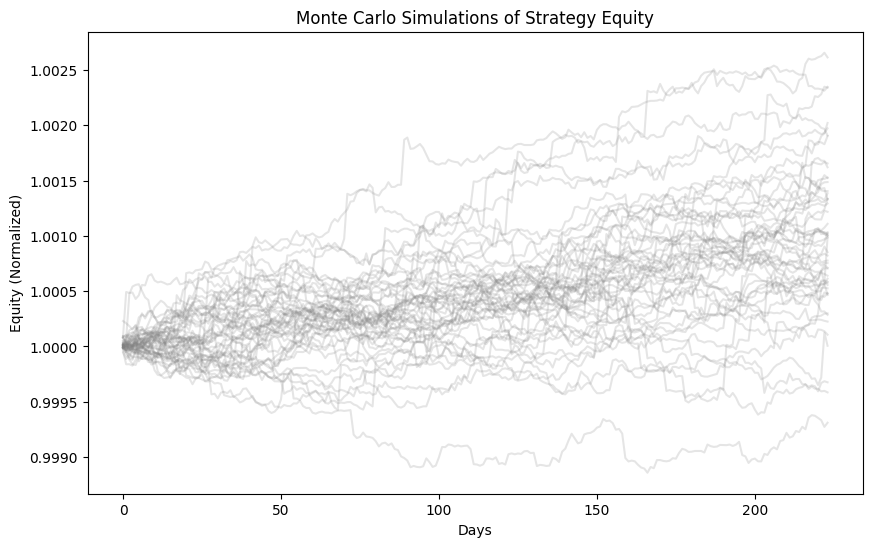

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Extract actual daily returns
returns = daily_ret['r'].dropna().values
n_days = len(returns)
n_sim = 1000

# Monte Carlo simulation (bootstrap with replacement)
sim_equity = []
for i in range(n_sim):
    sampled = np.random.choice(returns, size=n_days, replace=True)
    eq = (1 + sampled).cumprod()
    sim_equity.append(eq)

sim_equity = np.array(sim_equity)

# Compute statistics
final_equity = sim_equity[:, -1]
drawdowns = np.min(sim_equity / np.maximum.accumulate(sim_equity, axis=1) - 1, axis=1)

print(f"Mean Final Equity: {np.mean(final_equity):.3f}")
print(f"Prob(Equity < 1.0): {(np.mean(final_equity < 1.0)*100):.2f}%")
print(f"Mean Max Drawdown: {np.mean(drawdowns)*100:.2f}%")

# Visualization
plt.figure(figsize=(10,6))
for i in range(50):
    plt.plot(sim_equity[i], color='gray', alpha=0.2)
plt.title("Monte Carlo Simulations of Strategy Equity")
plt.xlabel("Days")
plt.ylabel("Equity (Normalized)")
plt.show()


🔹 Block 2 — Deflated Sharpe Ratio (DSR)
The Deflated Sharpe Ratio adjusts for luck, number of trials, and non-normality of returns.
It’s more realistic than the vanilla Sharpe ratio.

The Deflated Sharpe Ratio adjusts for luck, number of trials, and non-normality of returns.
It’s more realistic than the vanilla Sharpe ratio.

In [8]:
from scipy.stats import norm, skew, kurtosis

def deflated_sharpe_ratio(sharpe, n_obs, skewness, kurt):
    """
    Calculates Deflated Sharpe Ratio (Bailey & López de Prado, 2012)
    """
    sr_std = np.sqrt((1 - skewness * sharpe + ((kurt - 1) / 4) * sharpe**2) / (n_obs - 1))
    sr_deflated = (sharpe - 0) / sr_std
    return norm.cdf(sr_deflated)

# Calculate DSR
n_obs = len(daily_ret)
sk = skew(returns)
kt = kurtosis(returns)
dsr = deflated_sharpe_ratio(sharpe, n_obs, sk, kt)

print(f"Deflated Sharpe Ratio (probability true edge): {dsr:.2%}")
print(f"Return skewness: {sk:.2f}, kurtosis: {kt:.2f}")


Deflated Sharpe Ratio (probability true edge): 100.00%
Return skewness: 2.38, kurtosis: 21.35


🔹 Block 3 — Drawdown Probability Estimation
We’ll use the Monte Carlo runs to estimate:

“What’s the probability that my drawdown exceeds 10%, 20%, etc.?”

In [9]:
dd10 = np.mean(drawdowns < -0.10)
dd20 = np.mean(drawdowns < -0.20)

print(f"Probability(Drawdown > 10%): {dd10*100:.2f}%")
print(f"Probability(Drawdown > 20%): {dd20*100:.2f}%")


Probability(Drawdown > 10%): 0.00%
Probability(Drawdown > 20%): 0.00%


In [10]:
alphas = np.linspace(0.1, 2.0, 20)  # from 0.1x to 2x Kelly
results = []

for a in alphas:
    f_adj = valid_df['kelly_fraction'] * a
    strat_ret = f_adj * valid_df['Target']
    daily = strat_ret.groupby(valid_df['Date']).mean()
    
    # Metrics
    eq = (1 + daily).cumprod()
    peaks = np.maximum.accumulate(eq)
    dd = eq / peaks - 1
    
    sharpe = (daily.mean() / (daily.std() + 1e-9)) * np.sqrt(252)
    cagr = eq.iloc[-1]**(252/len(eq)) - 1
    mdd = dd.min()
    
    results.append((a, sharpe, cagr, mdd))

# Convert to DataFrame
opt_df = pd.DataFrame(results, columns=['Alpha', 'Sharpe', 'CAGR', 'MaxDD'])

# Find best Sharpe
best = opt_df.loc[opt_df['Sharpe'].idxmax()]

print("🔹 Optimal Kelly Multiplier Results")
print(opt_df)
print("\n✅ Best configuration:")
print(best)


🔹 Optimal Kelly Multiplier Results
    Alpha    Sharpe      CAGR     MaxDD
0     0.1  1.184061  0.000094 -0.000056
1     0.2  1.184180  0.000188 -0.000113
2     0.3  1.184219  0.000281 -0.000169
3     0.4  1.184239  0.000375 -0.000226
4     0.5  1.184251  0.000469 -0.000282
5     0.6  1.184259  0.000563 -0.000338
6     0.7  1.184265  0.000656 -0.000395
7     0.8  1.184269  0.000750 -0.000451
8     0.9  1.184272  0.000844 -0.000507
9     1.0  1.184275  0.000938 -0.000564
10    1.1  1.184277  0.001032 -0.000620
11    1.2  1.184279  0.001125 -0.000677
12    1.3  1.184280  0.001219 -0.000733
13    1.4  1.184282  0.001313 -0.000789
14    1.5  1.184283  0.001407 -0.000846
15    1.6  1.184284  0.001501 -0.000902
16    1.7  1.184285  0.001594 -0.000958
17    1.8  1.184285  0.001688 -0.001015
18    1.9  1.184286  0.001782 -0.001071
19    2.0  1.184287  0.001876 -0.001128

✅ Best configuration:
Alpha     2.000000
Sharpe    1.184287
CAGR      0.001876
MaxDD    -0.001128
Name: 19, dtype: float64
